In [44]:
#Save the below parameters to output.txt file
%logstart -o -r -t -q output.txt rotate

In [45]:
# General info
# using Adam Optimization
# Shuffling sources every epoch
# SCHUSTER's MARMOUSI MODEL

# General parameters
GPU=1      # which GPU to use
plot=True # Plot Intermediate results
sigma=10   # Initial model smoothness 
gpu_ids=[0,1]

# Inversion parameters
num_batches = 30
num_epochs = 5000

#gamma = 300  # Does not apply, Adam uses lr (learning rate) instead of gamma
# Adam learning rate
lr = 4

# Modeling parameters
freq = 30
dx = 10
nt = 800
dt = 0.0015
num_shots = 10
num_receivers_per_shot = 101

# receiver_spacing = # computed below from ny,dx and num_receivers_per_shot

# Close the ouput.txt file with saved parameters
%logstop 

In [46]:
# Need to restart runtime before this step
import time
import torch
import numpy as np
import scipy.ndimage
import scipy.io
import matplotlib.pyplot as plt
import deepwave
import os
import csv
import torch.nn as nn
from scipy.io import savemat
from skimage.transform import resize

In [47]:
def plotVel(starting):
    
    #create figure
    fig = plt.figure(figsize=(15,7))
    
    rows = 5
    columns = 5
    
    for i in range(25):
        fig.add_subplot(rows,columns,i+1)
        kk=starting+i
        filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/vmodel_train/vmodel'+str(starting+i)+'.mat'
        mat=scipy.io.loadmat(filename)['vmodel']
        #mat_resize=resize(mat, (101,101))
        mat_smooth=scipy.ndimage.gaussian_filter(mat,5)
        minval = np.min(mat)
        mat[np.arange(len(mat)), mat.argmin(axis=1)] = 2000
        print(np.min(mat))
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(mat_smooth)
        plt.axis('off')
        plt.tight_layout()

In [48]:
os.system('nvidia-smi')

0

2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0
2000.0


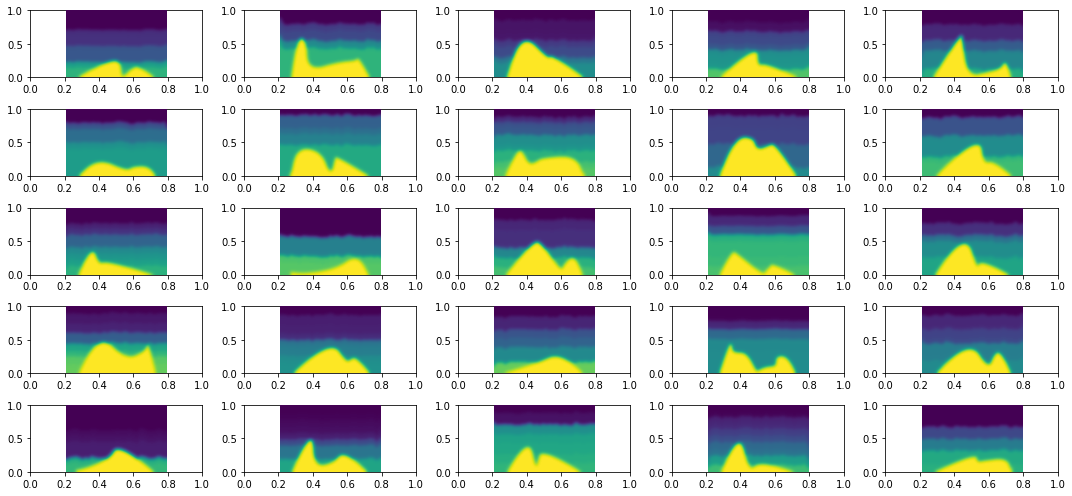

In [49]:
plotVel(100)

mat min: 2218.7441095074623
mat max: 4500.0


array([[2000.        , 2000.        , 2000.        , ..., 2000.        ,
        2000.        , 2000.        ],
       [2000.        , 2000.        , 2000.        , ..., 2000.        ,
        2000.        , 2000.        ],
       [2000.        , 2000.        , 2000.        , ..., 2000.        ,
        2000.        , 2000.        ],
       ...,
       [3329.48789152, 3329.48789152, 3329.48789152, ..., 3329.48789152,
        3329.48789152, 3329.48789152],
       [3329.48789152, 3329.48789152, 3329.48789152, ..., 3329.48789152,
        3329.48789152, 3329.48789152],
       [3329.48789152, 3329.48789152, 3329.48789152, ..., 3329.48789152,
        3329.48789152, 3329.48789152]])

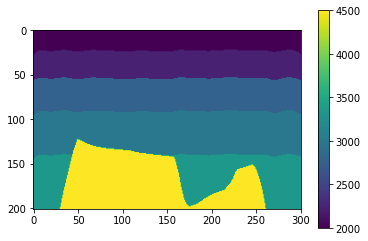

In [50]:
kk = 600
filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
mat=scipy.io.loadmat(filename)['vmodel']
print("mat min:", np.min(mat))
print("mat max:", np.max(mat))
mat[(mat==np.min(mat))] = 2000
np.shape(mat)
plt.imshow(mat)
plt.colorbar()
mat_resize = np.resize(mat,(101,101))
mat
#mat
#plt.imshow(newmat)
#type(mat)

In [51]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_train/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_train/')

0

In [52]:
#plot=True
# Load the true model
min1 = []
max1 = []
for kk in range(1,800):
    #kk=2
    filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
    mat=scipy.io.loadmat(filename)['vmodel']
    mat[(mat==np.min(mat))] = 2000
    mat=resize(mat,(101,101))
    #mat=mat[:-1,:-1]
    #mat = np.loadtxt('marmhard2.dat')
    #mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
    #RB Get model size
    ny = np.size(mat,1);
    nz = np.size(mat,0);
    #RB compute true model mean value and width for future model normalization
    max1=np.max(mat)
    min1=np.min(mat)
    med=(max1+min1)/2.
    wid=(max1-min1)/2.

    print('vmin=',min1,'vmax=',max1,'vmed=',med,'vwidth=',wid)
    torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
    GPU_string='cuda:'+str(GPU)
    device = torch.device(GPU_string)
    num_dims = 2
    #num_shots = 32
    num_sources_per_shot = 1
    #num_receivers_per_shot = 200

    #RB source_spacing = 25.0
    #RB receiver_spacing = 10.0
    source_spacing = ny * dx / num_shots
    receiver_spacing = ny * dx / num_receivers_per_shot
    print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
    print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
          'ds=',source_spacing,'dr=',receiver_spacing)
    
    # Create arrays containing the source and receiver locations
    # x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
    # x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
    x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
    x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
    #x_s[:, 0, 0] = 100. #RB Set source depth

    x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
    x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
    x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

    #RB Shuffle shot coordinates
    ###idx = torch.randperm(num_shots)
    ###x_s = x_s.view(-1,2)[idx].view(x_s.size())

    #RB Set Receiver depth
    #x_r[0, :, 0] = 100.
    #x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

    # Create true source amplitudes [nt, num_shots, num_sources_per_shot]
    # I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
    # can use whatever Tensor you want as the source amplitude.
    source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                              .reshape(-1, 1, 1)
                              .repeat(1, num_shots, num_sources_per_shot))
    
    model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
    prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
    receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), dt).cpu()
    
    vel=np.squeeze(mat)
    seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
    seis = seis.swapaxes(1,2)
    mdic = {"Rec":seis}
    
    print(np.shape(seis))
    file1 = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/georec_train/georec'+str(kk)+'.mat','wb')
    savemat(file1, mdic)
    file1.close()
    #file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainA/'+str(kk)+'.npy','wb')
    #np.save(file1,seis)
    #file1.close()
    
    min1 = np.append(min1,np.min(vel))
    max1 = np.append(max1,np.max(vel))

vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 1999.9999999999998 vmax= 4500.0 vmed= 3250.0 vwidth= 1250.0
ny= 101 nz= 101 nt= 800 dx= 10 freq= 30
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101,

In [32]:
mat

array([[2000.        , 2000.        , 2000.        , ..., 2000.        ,
        2000.        , 2000.        ],
       [2000.        , 2000.        , 2000.        , ..., 2000.        ,
        2000.        , 2000.        ],
       [2000.        , 2000.        , 2000.        , ..., 2000.        ,
        2000.        , 2000.        ],
       ...,
       [3610.02197856, 3610.02197856, 3610.02197856, ..., 3610.02197856,
        3610.02197856, 3610.02197856],
       [3610.02197856, 3610.02197856, 3610.02197856, ..., 3610.02197856,
        3610.02197856, 3610.02197856],
       [3610.02197856, 3610.02197856, 3610.02197856, ..., 3610.02197856,
        3610.02197856, 3610.02197856]])

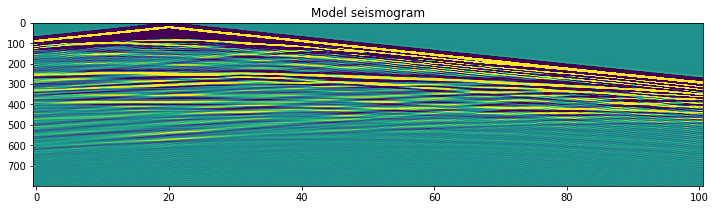

In [33]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

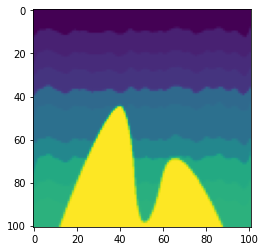

In [34]:
plt.imshow(mat)

In [108]:
os.system('rm -rf /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/')
os.system('mkdir /disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/')

0

In [109]:
#plot=True
# Load the true model
min1 = []
max1 = []
for kk in range(100,150):
    #kk=2
    #filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/vmodel_test/vmodel'+str(kk)+'.mat'
    filename='/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/train_data/SimulateData/vmodel_train/vmodel'+str(kk)+'.mat'
    mat=scipy.io.loadmat(filename)['vmodel']
    mat[np.arange(len(mat)), mat.argmin(axis=1)] = 2000
    mat=resize(mat,(101,101))
    #mat=mat[:-1,:-1]
    #mat = np.loadtxt('marmhard2.dat')
    #mat = np.pad(mat,((10,0),(0,0)),'edge') #RB add some water layer
    #RB Get model size
    ny = np.size(mat,1);
    nz = np.size(mat,0);
    #RB compute true model mean value and width for future model normalization
    max=np.max(mat)
    min=np.min(mat)
    med=(max+min)/2.
    wid=(max-min)/2.

    print('vmin=',min,'vmax=',max,'vmed=',med,'vwidth=',wid)
    torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
    GPU_string='cuda:'+str(GPU)
    device = torch.device(GPU_string)
    num_dims = 2
    #num_shots = 32
    num_sources_per_shot = 1
    #num_receivers_per_shot = 200

    #RB source_spacing = 25.0
    #RB receiver_spacing = 10.0
    source_spacing = ny * dx / num_shots
    receiver_spacing = ny * dx / num_receivers_per_shot
    print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
    print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
          'ds=',source_spacing,'dr=',receiver_spacing)
    
    # Create arrays containing the source and receiver locations
    # x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
    # x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
    x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
    x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
    #x_s[:, 0, 0] = 100. #RB Set source depth

    x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
    x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
    x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

    #RB Shuffle shot coordinates
    ###idx = torch.randperm(num_shots)
    ###x_s = x_s.view(-1,2)[idx].view(x_s.size())

    #RB Set Receiver depth
    #x_r[0, :, 0] = 100.
    #x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

    # Create true source amplitudes [nt, num_shots, num_sources_per_shot]
    # I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
    # can use whatever Tensor you want as the source amplitude.
    source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                              .reshape(-1, 1, 1)
                              .repeat(1, num_shots, num_sources_per_shot))
    
    model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
    prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
    receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                    x_s.to(device),
                                    x_r.to(device), dt).cpu()
    
    vel=np.squeeze(mat)
    seis=np.squeeze(receiver_amplitudes_all.cpu().detach().numpy())
    seis = seis.swapaxes(1,2)
    mdic = {"Rec":seis}
    
    print(np.shape(seis))
    file1 = open('/disk/student/adhara/Fall2021/FCNVMB-Deep-learning-based-seismic-velocity-model-building/data/test_data/SimulateData/georec_test/georec'+str(kk)+'.mat','wb')
    savemat(file1, mdic)
    file1.close()
    #file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainA/'+str(kk)+'.npy','wb')
    #np.save(file1,seis)
    #file1.close()
    
    min1 = np.append(min1,np.min(vel))
    max1 = np.append(max1,np.max(vel))

vmin= 2262.2223531539616 vmax= 4500.0 vmed= 3381.111176576981 vwidth= 1118.8888234230192
ny= 101 nz= 101 nt= 800 dx= 10 freq= 15
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 2270.7622966345516 vmax= 4500.0 vmed= 3385.381148317276 vwidth= 1114.6188516827242
ny= 101 nz= 101 nt= 800 dx= 10 freq= 15
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 2135.0535380394313 vmax= 4500.0 vmed= 3317.5267690197156 vwidth= 1182.4732309802844
ny= 101 nz= 101 nt= 800 dx= 10 freq= 15
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 2271.5008706699437 vmax= 4500.0 vmed= 3385.750435334972 vwidth= 1114.2495646650282
ny= 101 nz= 101 nt= 800 dx= 10 freq= 15
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 2527.8415480623958 vmax= 4500.0 vmed= 3513.9207740311977 vwidth= 986.0792259688021
ny= 101 nz= 101 nt= 800 dx= 10 freq= 15
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 2417.8702024548697 vmax= 4500.0 vmed= 3458.9351012274

vmin= 2167.0065617245764 vmax= 4500.0 vmed= 3333.503280862288 vwidth= 1166.4967191377118
ny= 101 nz= 101 nt= 800 dx= 10 freq= 15
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 2136.607581533116 vmax= 4500.0 vmed= 3318.303790766558 vwidth= 1181.696209233442
ny= 101 nz= 101 nt= 800 dx= 10 freq= 15
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)
vmin= 2036.4817907464676 vmax= 4500.0 vmed= 3268.240895373234 vwidth= 1231.7591046267662
ny= 101 nz= 101 nt= 800 dx= 10 freq= 15
shots= 10 recs/shot= 101 ds= 101.0 dr= 10.0
(800, 101, 10)


In [57]:
x_r[1,1,:]

tensor([ 0., 10.])

In [110]:
print(np.min(min1))

2003.341538981923


In [ ]:
print(np.max(max1))

In [ ]:
np.max(VelK)

In [ ]:
f1 = np.load('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(1)+'.npy')
f1 = np.load('/glb/data/eptr_am_2/Arnab/seismogram/trainB/'+str(1)+'.npy')
np.shape(f1)

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(mat,vmin=min,vmax=max, aspect=1)
    plt.title('True model')
    plt.colorbar()

In [ ]:
# Specify which GPU to use (in multi GPU machines)
torch.cuda.set_device(GPU)  #RB Necessary if device <> 0
GPU_string='cuda:'+str(GPU)
device = torch.device(GPU_string)

In [ ]:
# Set parameters
##freq = 14
##dx = 10
##dt = 0.001

#RB nt = int(2 / dt) # 2s
#nt = int(0.9 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt))
#nt =       3 * int(np.sqrt((nz*dx)**2 + (ny*dx)**2) / 2000 / dt)
##nt = 4001

num_dims = 2
#num_shots = 32
num_sources_per_shot = 1
#num_receivers_per_shot = 200

#RB source_spacing = 25.0
#RB receiver_spacing = 10.0
source_spacing = ny * dx / num_shots
receiver_spacing = ny * dx / num_receivers_per_shot
#receiver_spacing = 8.

print('ny=',ny,'nz=',nz,'nt=',nt,'dx=',dx,'freq=',freq)
print('shots=',num_shots,'recs/shot=',num_receivers_per_shot, \
      'ds=',source_spacing,'dr=',receiver_spacing)


In [ ]:
# Create arrays containing the source and receiver locations
# x_s: Source locations [num_shots, num_sources_per_shot, num_dimensions]
# x_r: Receiver locations [num_shots, num_receivers_per_shot, num_dimensions]
x_s = torch.zeros(num_shots, num_sources_per_shot, num_dims)
x_s[:, 0, 1] = torch.arange(num_shots).float() * source_spacing
#x_s[:, 0, 0] = 100. #RB Set source depth

x_r = torch.zeros(num_shots, num_receivers_per_shot, num_dims)
x_r[0, :, 1] = torch.arange(num_receivers_per_shot).float() * receiver_spacing
x_r[:, :, 1] = x_r[0, :, 1].repeat(num_shots, 1)

#RB Shuffle shot coordinates
###idx = torch.randperm(num_shots)
###x_s = x_s.view(-1,2)[idx].view(x_s.size())

#RB Set Receiver depth
#x_r[0, :, 0] = 100.
#x_r[:, :, 0] = x_r[0, :, 0].repeat(num_shots, 1)

# Create true source amplitudes [nt, num_shots, num_sources_per_shot]
# I use Deepwave's Ricker wavelet function. The result is a normal Tensor - you
# can use whatever Tensor you want as the source amplitude.
source_amplitudes_true = (deepwave.wavelets.ricker(freq, nt, dt, 1/freq)
                          .reshape(-1, 1, 1)
                          .repeat(1, num_shots, num_sources_per_shot))

In [ ]:
model_true = torch.Tensor(mat) # Convert to a PyTorch Tensor
prop = deepwave.scalar.Propagator({'vp': model_true.to(device)}, dx)
receiver_amplitudes_all = prop(source_amplitudes_true.to(device),
                                x_s.to(device),
                                x_r.to(device), dt).cpu()

In [ ]:
receiver_amplitudes_all.shape

In [ ]:
if plot==True:
    plt.figure(figsize=(12, 3))
    plt.imshow(receiver_amplitudes_all[:,2].cpu().detach().numpy(),vmin=-.05,vmax=.05, aspect='auto')
    plt.title('Model seismogram')

In [ ]:
vel=mat
seis=receiver_amplitudes_all.cpu().detach().numpy()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainvel/'+str(kk)+'.npy','wb')
np.save(file1,vel)
file1.close()
file1 = open('/glb/data/eptr_am_2/Arnab/seismogram/trainseis/'+str(kk)+'.npy','wb')
np.save(file1,seis)
file1.close()

In [ ]:
np.shape(seis)

In [ ]:
np.shape(vel)